In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

In [2]:
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 장치를 사용합니다:", DEVICE)

다음 장치를 사용합니다: cpu


In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [5]:
# 생성자 (Generator)
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh()
)

In [6]:
# 판별자 (Discriminator)
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [7]:
# GAN 구현
D = D.to(DEVICE)
G = G.to(DEVICE)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [8]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)

        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # D가 진짜 이미지를 진짜로 인식하는 오차 계산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # D가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake

        # D 모델 학습
        d_optimizer.zero_grad()
        g_optimizer.zero_grad() 
        d_loss.backward()
        d_optimizer.step()

        # G가 생성해낸 가짜 이미지로 D를 잘 속였는지에 대한 오차 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)

        # G 모델 학습
        d_optimizer.zero_grad() 
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
    print(f"epoch [{epoch}/{EPOCHS}] d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, \
    D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}")

epoch [0/500] d_loss: 0.0545, g_loss: 3.8908,     D(x): 0.98, D(G(z)): 0.03
epoch [1/500] d_loss: 0.0172, g_loss: 5.6056,     D(x): 1.00, D(G(z)): 0.01
epoch [2/500] d_loss: 0.0596, g_loss: 6.7026,     D(x): 0.99, D(G(z)): 0.04
epoch [3/500] d_loss: 0.0731, g_loss: 5.6911,     D(x): 0.97, D(G(z)): 0.01
epoch [4/500] d_loss: 0.0610, g_loss: 5.7837,     D(x): 0.97, D(G(z)): 0.02
epoch [5/500] d_loss: 0.0271, g_loss: 4.7752,     D(x): 1.00, D(G(z)): 0.02
epoch [6/500] d_loss: 0.1296, g_loss: 4.8012,     D(x): 0.97, D(G(z)): 0.08
epoch [7/500] d_loss: 0.1692, g_loss: 4.8655,     D(x): 0.95, D(G(z)): 0.07
epoch [8/500] d_loss: 0.2778, g_loss: 3.7792,     D(x): 0.94, D(G(z)): 0.13
epoch [9/500] d_loss: 0.1490, g_loss: 3.8748,     D(x): 0.95, D(G(z)): 0.05
epoch [10/500] d_loss: 0.2311, g_loss: 4.6494,     D(x): 0.93, D(G(z)): 0.06
epoch [11/500] d_loss: 0.2515, g_loss: 4.0016,     D(x): 0.94, D(G(z)): 0.09
epoch [12/500] d_loss: 0.2477, g_loss: 4.1999,     D(x): 0.93, D(G(z)): 0.06
epoch [13

KeyboardInterrupt: ignored

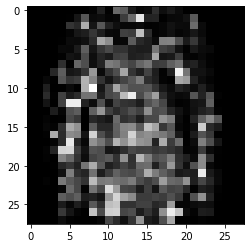

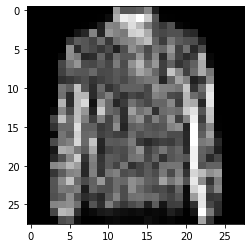

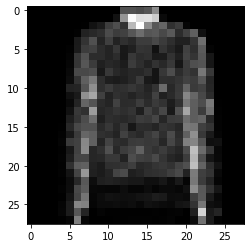

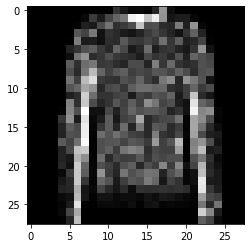

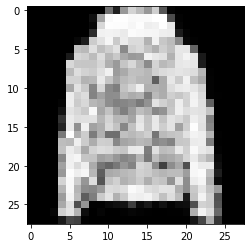

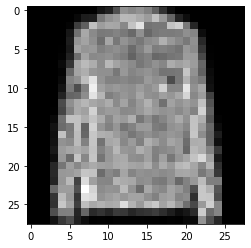

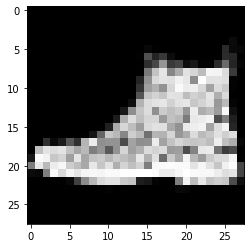

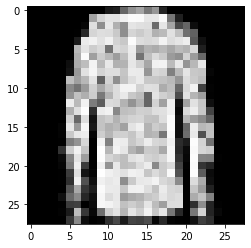

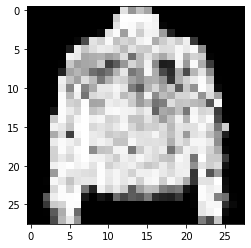

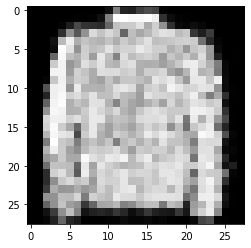

In [9]:
# 무작위 텐서로 생성자의 결과물 시각화하기
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img =  np.reshape(fake_images.data.cpu().numpy()[i], (28,28))
    plt.imshow(fake_images_img, cmap='gray')
    plt.show()

### cGAN으로 생성 제어하기

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [6]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [8]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)

        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)   # '진짜' 레이블
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)  # '가짜' 레이블

        # D가 real_image를 real로 인식하는 오차 계산
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # 무작위로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)

        # D와 fake_image를 fake로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # D의 최종 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # D 학습 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # G가 D를 잘 속였는지에 대한 오차
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # G 학습 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"이폭 [{epoch}/{EPOCHS}] d_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f} D(x): {real_score.mean().item():.2f} D(G(z)): {fake_score.mean().item():.2f}")

이폭 [0/500] d_loss: 0.6034 g_loss: 2.7430 D(x): 0.82 D(G(z)): 0.20
이폭 [1/500] d_loss: 0.5496 g_loss: 3.7684 D(x): 0.80 D(G(z)): 0.10
이폭 [2/500] d_loss: 0.3544 g_loss: 4.5030 D(x): 0.94 D(G(z)): 0.15
이폭 [3/500] d_loss: 0.2171 g_loss: 3.1946 D(x): 0.97 D(G(z)): 0.13
이폭 [4/500] d_loss: 0.4680 g_loss: 3.4445 D(x): 0.85 D(G(z)): 0.11
이폭 [5/500] d_loss: 0.5290 g_loss: 1.9246 D(x): 0.86 D(G(z)): 0.20
이폭 [6/500] d_loss: 0.5535 g_loss: 2.5037 D(x): 0.80 D(G(z)): 0.17
이폭 [7/500] d_loss: 0.8224 g_loss: 1.9230 D(x): 0.73 D(G(z)): 0.25
이폭 [8/500] d_loss: 0.6520 g_loss: 1.7981 D(x): 0.82 D(G(z)): 0.26
이폭 [9/500] d_loss: 0.5735 g_loss: 1.7084 D(x): 0.82 D(G(z)): 0.24
이폭 [10/500] d_loss: 0.7989 g_loss: 1.4551 D(x): 0.70 D(G(z)): 0.26
이폭 [11/500] d_loss: 0.9207 g_loss: 1.5408 D(x): 0.70 D(G(z)): 0.29
이폭 [12/500] d_loss: 0.7258 g_loss: 1.4926 D(x): 0.76 D(G(z)): 0.27
이폭 [13/500] d_loss: 0.6775 g_loss: 1.7161 D(x): 0.81 D(G(z)): 0.27
이폭 [14/500] d_loss: 0.9181 g_loss: 1.4905 D(x): 0.68 D(G(z)): 0.29


KeyboardInterrupt: ignored

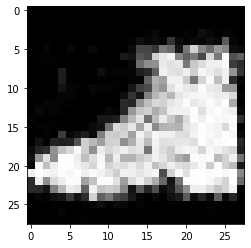

In [16]:
item_number = 9
z = torch.randn(1, 100).to(DEVICE)
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)

sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0], (28,28))

plt.imshow(sample_images_img, cmap='gray')
plt.show()